**Transfer Learning Example using VGG19 as backbone with custom output layer.**

This code uses TF data pipeline to feed data from custom generator to NN model. The code also uses augmented data created by custom functions. The code was prepared for a Kaggle competition Teenmagi-2022.

[Kaggle Teenmagi-2022](https://www.kaggle.com/c/teenmagi-2022)

In [1]:
#VGG19 Neural NW; Image Scaling using Gaussian Pyramid; Filters; Data Generartor using TF pipeline; Augmentator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from numpy import load

import gc
import cv2
import pandas as pd


#========== Neural NW
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import LeakyReLU

from IPython.display import Javascript
from IPython.display import FileLink


print("Libraries Loaded")

Libraries Loaded


In [2]:
def Data_Loader(Batch_number):
    path ='../input/processed-batches/Batch' + str(Batch_number) 
    dict_Batch_X = load(path + '_X.npz')
    dict_Batch_Y = load(path + '_Y.npz')
    Xa = dict_Batch_X['arr_0']
    Ya = dict_Batch_Y['arr_0']
    print("Batch"+ str(Batch_number)+":", "Training Data Dim", Xa.shape,"  Label Data Dim:", Ya.shape)
    del dict_Batch_X
    del dict_Batch_Y
    return Xa, Ya



Test_Batch = 2


X_TEST, Y_TEST =  Data_Loader(Test_Batch)
X_TEST = X_TEST[:,:,:,0]  #single channel mode


X, Y = Data_Loader(1)

X = X[:,:,:,0]  #single channel mode
Y=Y.astype(np.int16)
#X=X.astype(np.float16)
print("(X_TEST) Test Dataset's Dimensions:" ,X_TEST.shape,"label Dim: ", Y_TEST.shape)
print("(X)      Training Dataset's Dimensions:" ,X.shape,"label Dim: ", Y.shape)
#print("Validation Dataset's Dimensions:" ,Val.shape)
print()


#Split Test images to Validation and Test
X_Tst, X_Val, Y_Tst, Y_Val = train_test_split(X_TEST, Y_TEST, test_size=0.5, random_state=0, stratify=Y_TEST)
print("Split Test Dataset's Dimensions:" ,X_Tst.shape,"label Dim: ", Y_Tst.shape)

#### X_Tst will stay hidden at all times

Y_Tst=Y_Tst.astype(np.int16)
Y_Val=Y_Tst.astype(np.int16)

#Convert to one-hot
Y_Val=tf.one_hot(Y_Val, 1000)
Y_Tst=tf.one_hot(Y_Tst, 1000)
Y=tf.one_hot(Y, 1000)


gc.collect()

Batch2: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Batch1: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
(X_TEST) Test Dataset's Dimensions: (100000, 8, 8) label Dim:  (100000,)
(X)      Training Dataset's Dimensions: (100000, 8, 8) label Dim:  (100000,)

Split Test Dataset's Dimensions: (50000, 8, 8) label Dim:  (50000,)


2022-07-19 16:48:19.818461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 16:48:19.827479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 16:48:19.828200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 16:48:19.829370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

54

Created new Augmentator to fix some bugs, easier to use and more intutive

In [3]:
def Augmentator(Image_Batch, Label=0, crop_level=1, Append=True):
    y = Label
    Labels_available = isinstance(y, (list, tuple, np.ndarray, tf.Tensor))
    template_h_1x1 = np.array([[0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1], 
                               [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1],
                               [1,1,1,1,1,1,1,1], [0,0,0,0,0,0,0,0]]).astype('uint8')
    
    template_h_2x1 = np.array([[0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1], 
                               [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1],
                               [1,1,1,1,1,1,1,1], [0,0,0,0,0,0,0,0]]).astype('uint8')
    
   

    if Append==True: #Will include original data (may or may not include labels)
        if Labels_available==False: #y==0:  #No labels, only data augment useful for pred.

            if crop_level==1: #only append 1x1 to orig. img data, labels not required
                New_Batch = np.multiply(Image_Batch,template_h_1x1)
                New_Batch = np.concatenate( (Image_Batch,New_Batch), axis=0 )
        
            elif crop_level==2: #only append 2x1 to orig. img data, labels not required
                New_Batch = np.multiply(Image_Batch,template_h_1x1)
                New_Batch = np.concatenate( (Image_Batch,New_Batch), axis=0 ) #1x1 & Orig.

                New_Batch2 = np.multiply(Image_Batch,template_h_2x1)
                New_Batch = np.concatenate( (New_Batch,New_Batch2), axis=0 ) #1x1 & Orig. & 2x1

            return New_Batch
        
        elif Labels_available==True: #label array present:useful for train and test cases where labels are also required and dataset is increased
            
            if crop_level==1: #1x1 & original case
                New_Batch = np.multiply(Image_Batch,template_h_1x1) #create 1x1 cases and append to original
                New_Batch = np.concatenate( (Image_Batch,New_Batch), axis=0 )
                New_Label = np.concatenate( (y,y), axis=0 )  #Repeat labels for all new images
        
            elif crop_level==2: #2x1 & original
                New_Batch2 = np.multiply(Image_Batch,template_h_2x1) #create 2x1 and append with original ones
                New_Batch = np.concatenate( (Image_Batch,New_Batch2), axis=0 )
                New_Label = np.concatenate( (y,y), axis=0 )  #Repeat labels for all new images
            
            elif crop_level==3: #2x1 & 1x1 & original
                New_Batch2 = np.multiply(Image_Batch,template_h_2x1) #create 2x1
                New_Batch3 = np.multiply(Image_Batch,template_h_1x1) #create 1x1
                New_Batch = np.concatenate( (Image_Batch,New_Batch3), axis=0 ) #Original & 1x1
                New_Batch = np.concatenate( (New_Batch,New_Batch2), axis=0 ) #Original & 1x1 & 2x1
                New_Label = np.concatenate( (y,y), axis=0 )  #Labels 1+1 times
                New_Label = np.concatenate( (New_Label,y), axis=0 )  #Labels 2+1 times

            return New_Batch, New_Label
            
    elif Append==False: #Will not include original data (may or may not include labels)
        
        if Labels_available==False:
            
            if crop_level==1: ##only replace and no append for 1x1
                Image_Batch = np.multiply(Image_Batch,template_h_1x1) #1x1 imgs
                return Image_Batch
            
            elif crop_level==2: ## only replace and no append for 2x1
                New_Batch2 = np.multiply(Image_Batch,template_h_2x1)  #2x1 imgs
                return New_Batch2

        elif Labels_available==True:
            
            if crop_level==2: #append only 1x1 and 2x1 (no original data)
                New_Batch2 = np.multiply(Image_Batch,template_h_2x1)  #2x1 imgs
                Image_Batch = np.multiply(Image_Batch,template_h_1x1)  #1x1 imgs
                New_Batch2 = np.concatenate( (Image_Batch,New_Batch2), axis=0 ) #1x1 and 2x1 imgs appended
                New_Label2 = np.concatenate( (y,y), axis=0 )  #1+1 Labels
                return New_Batch2, New_Label2
        

def Image_Pyramid_Scaler(image, filter_flag, cv_flag,channels=1):
    kernel_Sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]).astype(np.int8)
    
    levels = 2  #1-32   2-64  3-128    4-256
     
    if filter_flag==1:
        
        image = cv2.filter2D(image, -1, kernel_Sharp)
    
    if cv_flag == 0:
        larger = cv2.pyrUp(image)
        for i in range(levels):
            larger = cv2.pyrUp(larger)
       #larger = larger[:,:,0]    #only if img is of 3 channel and needs to be in 1ch
    else:  
        larger = cv2.resize(image, (64,64), interpolation = cv2.INTER_LANCZOS4) #INTER_CUBIC  INTER_LINEAR INTER_NEAREST INTER_AREA
    if channels == 3:
        larger = np.stack((larger,)*3, axis=-1) #convert (256,256) to (256,256,3) 
    
    return larger  #.astype(np.float16)


def Tflow_Custom_Generator(X_Dat, LBL):   
    def generator():
        for i in range(len(X_Dat)):
            image = Image_Pyramid_Scaler(X_Dat[i], 0, 0, 3)  #filter_flag, cv_flag, channels_flag  .astype(np.float32)
            label = LBL[i]
            # The generator-y part: yield the next training batch            
            yield image, label
    return generator

(8, 8)
(64, 64, 3)


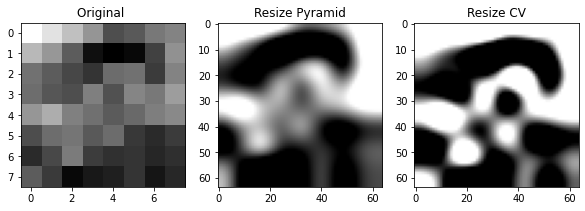

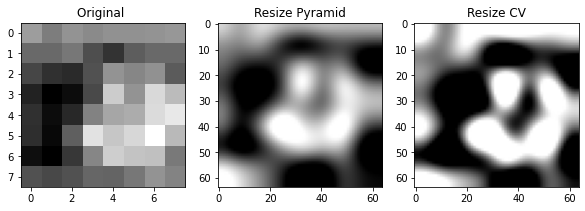

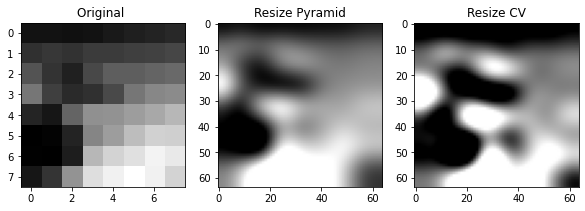

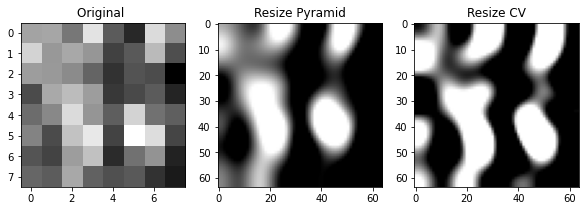

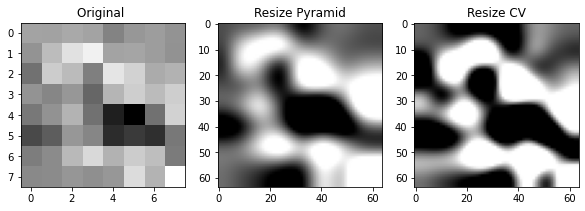

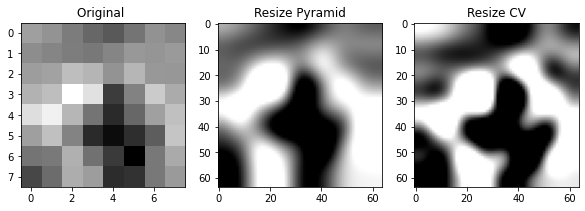

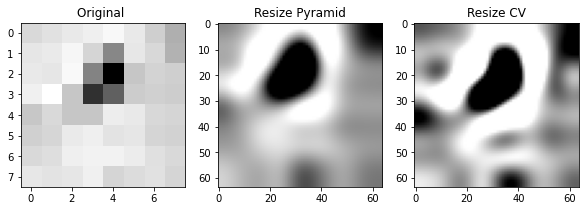

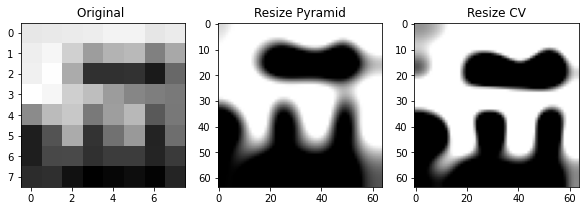

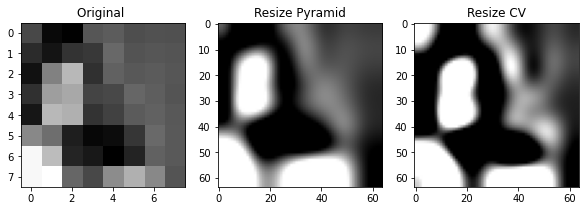

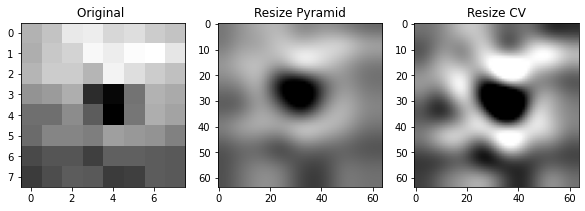

In [4]:
image = X[0]
print(image.shape)
image_Resized_Pyramid = Image_Pyramid_Scaler(image, 1, 0, 3)  #filter_flag, cv_flag, channels_flag  .astype(np.float32)
print(image_Resized_Pyramid.shape)




for i in range(0,100,10):
    fig, axs = plt.subplots(1, 3,figsize=(10, 10))
    image = X[i]
    
    image_Resized_Pyramid = Image_Pyramid_Scaler(image, 1, 0, 3)  #filter_flag, cv_flag, channels_flag  .astype(np.float32)
    image_Resized_CV = Image_Pyramid_Scaler(image, 1, 1, 3)  #filter_flag, cv_flag, channels_flag  .astype(np.float32)
    
    axs[0].set_title('Original ') #+str(np.argmax(Y[i]))
    axs[0].imshow(image, cmap='gray')
    axs[1].set_title('Resize Pyramid')
    axs[1].imshow(image_Resized_Pyramid, cmap='gray')
    axs[2].set_title('Resize CV')
    axs[2].imshow(image_Resized_CV, cmap='gray')

**Setup image shape, Generators, Batch size, Augmentation, Tensorflow Pipeline**

In [5]:
x_shape = (64,64,3)
y_shape = (1000)  # A single item (not array). 1000 for 1 hot

#AUTOTUNE = tf.data.AUTOTUNE
#print("AUTOTUNE:",AUTOTUNE)
#AUTOTUNE = 50

#batch_size = 250
#Test_batch_size = 500



batch_size = 80
Test_batch_size = 160


## ==================== train Gen. is in For loop

###===================== Validation Gen.

#X_Val = Augmentator(X_Val, Label=0, crop_level=1, Append=False) #Replace all test data with Hcrop_1x1 values


#validation_generator = Tflow_Custom_Generator(X_Val, Y_Val) #Custom generator to Resize images
#validation_dataset = tf.data.Dataset.from_generator(generator=validation_generator, output_types=(tf.float32, tf.int16), 
#                                         output_shapes=(x_shape, y_shape) )

#validation_dataset = validation_dataset.shuffle(100, reshuffle_each_iteration=True)

# Parallelize the augmentation.
#dataset = dataset.map( augment, num_parallel_calls=AUTOTUNE, deterministic=False )  # Order does not matter.
#validation_dataset = validation_dataset.repeat().batch(batch_size, drop_remainder=False) #, num_parallel_calls=AUTOTUNE

# Prefetch some batches.
#validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)


###===================== Test Gen.

X_Tst = Augmentator(X_Tst, Label=0, crop_level=1, Append=False) #Replace all test data with Hcrop_1x1 values

Test_generator = Tflow_Custom_Generator(X_Tst, Y_Tst) #Custom generator to Resize images
Test_dataset = tf.data.Dataset.from_generator(generator=Test_generator, output_types=(tf.float32, tf.int16), 
                                         output_shapes=(x_shape, y_shape) )

Test_dataset = Test_dataset.shuffle(100, reshuffle_each_iteration=True)

# Parallelize the augmentation.
#Test_dataset = Test_dataset.map( augment, num_parallel_calls=AUTOTUNE, deterministic=False )  # Order does not matter.

Test_dataset = Test_dataset.repeat().batch(Test_batch_size, drop_remainder=False) # num_parallel_calls=AUTOTUNE

# Prefetch some batches.
Test_dataset = Test_dataset.prefetch(tf.data.AUTOTUNE)




In [6]:
channel=3
size=64

image_input = tf.keras.layers.Input(shape=(size,size, channel))  #Line 2
baseModel_VGG_19 = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_tensor=image_input)     #Line 3
#baseModel_VGG_19.summary()  #Line 4

print("---------------------------------------------")
layer_dict = dict([(layer.name, layer) for layer in baseModel_VGG_19.layers])
outputa = layer_dict['block2_pool'].output
new_model = tf.keras.Model(inputs=baseModel_VGG_19.input, outputs=outputa)
#new_model.summary()
y = tf.keras.layers.GlobalAveragePooling2D()(new_model.output)
#FC_layer_Flatten = tf.keras.layers.Flatten()()        #Line 5
BatchNorm = tf.keras.layers.BatchNormalization()(y)

#Dense=tf.keras.layers.Dense(units=1024,activation=LeakyReLU(alpha=0.08),kernel_regularizer='l1',kernel_initializer =tf.keras.initializers.HeNormal(seed=None))(BatchNorm)    #Line 6
#BatchNorm = tf.keras.layers.BatchNormalization()(Dense)
#Dropout = tf.keras.layers.Dropout(.5)(BatchNorm)

Dense=tf.keras.layers.Dense(units=2048,activation=LeakyReLU(alpha=0.08),kernel_regularizer='l1',kernel_initializer =tf.keras.initializers.HeNormal(seed=None))(BatchNorm)    #Line 6
BatchNorm = tf.keras.layers.BatchNormalization()(Dense)
#Dropout = tf.keras.layers.Dropout(.5)(BatchNorm)

Classification=tf.keras.layers.Dense(units=1000,activation='softmax')(BatchNorm)  #(Dropout) #Line 11
model_final = tf.keras.Model(inputs=image_input,outputs=Classification) #Line 12

base_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=50000,
    decay_rate=0.9)  #Line 13
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])  #Line 14

model_final.summary()    #Line 13

---------------------------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (

**Use next two blocks to auto download trained weights from Kaggle**

In [ ]:
model_final.save('tst3.h5')
FileLink(r'./tst3.h5')

In [ ]:
def url_converter(insert_name,url): #Converts url of specific file like tst3.h5 to any other file link
    split = url.split('tst3.h5', 1)
    out=split[0] + insert_name + split[1]
    return out

def window_open(url):
    display(Javascript('window.open("{url}", "_blank");'.format(url=url)))


original_link = 'https://kkb-production.jupyter-proxy.kaggle.net/k/101245918/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..fjXk1hooM6LOrIv0mgUs9w.74TDukpu-xAHH5Q0pgpnO3ZfJ6fq8JoFZHFz9auNboAXuyjYZVNJvoEqzcGohACVU8ASsBS1eM3iwYsQMlothTXeTBu3tLtIxlM-C0LNefiQUTCWA93cQ8000safc0jSJYnGlDKPUzk5q9dOJ1127RWC9d7e6JgmomGbGd7LnoNZUVE4ajTM2tImCdcAvGG1JwnNeGIRX50DvjRkdLPeYg.7Qgz12tXiNMBkTs2sG8yOQ/proxy/files/tst3.h5?_xsrf=2%7Ca3c1899d%7C4abc445398aad0e1da8a1325d25c75b7%7C1658157760'



file_name='tst3.h5'
url = url_converter(file_name,original_link)
window_open(url)

####use this to get session url
#FileLink(r'./tst2.h5') #or this <a href="./tst.h5"> Download</a> 
#model_final.save('tst2.h5')




**Use this to Load Pre-trained weights**

In [ ]:
#model_final.load_weights('../input/weight-batch10/Weights_1x1_pass8_noloop2_Batch4(1).h5')
model_final.load_weights('../input/weight-batch10/Weights_1x1_pass9_noloop_Batch13.h5')
model_final.summary()

**Batch Training using Tensorflow Pipeline**

Batch1: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5


2022-07-19 16:48:52.759694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 16:48:58.374599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 103s 76ms/step - loss: 26.0058 - accuracy: 0.0029
Epoch 2/5
1250/1250 [==============================] - 97s 78ms/step - loss: 7.1365 - accuracy: 0.0061
Epoch 3/5
1250/1250 [==============================] - 96s 77ms/step - loss: 7.0383 - accuracy: 0.0080
Epoch 4/5
1250/1250 [==============================] - 96s 77ms/step - loss: 6.9542 - accuracy: 0.0095
Epoch 5/5
312/312 [==============================] - 37s 116ms/step - loss: 14.2544 - accuracy: 0.0016
Accuracy of Test data is: 0.16025641234591603 %


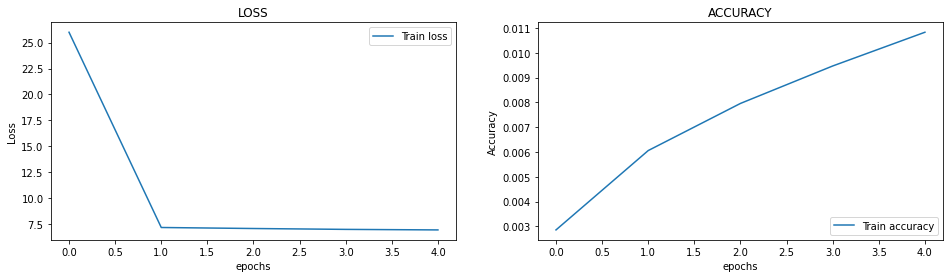




Batch3: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 101s 77ms/step - loss: 6.9288 - accuracy: 0.0097
Epoch 2/5
1250/1250 [==============================] - 96s 77ms/step - loss: 6.9005 - accuracy: 0.0111
Epoch 3/5
1250/1250 [==============================] - 97s 77ms/step - loss: 6.8838 - accuracy: 0.0121
Epoch 4/5
1250/1250 [==============================] - 96s 77ms/step - loss: 6.8448 - accuracy: 0.0137
Epoch 5/5
312/312 [==============================] - 36s 116ms/step - loss: 8.5667 - accuracy: 0.0034
Accuracy of Test data is: 0.33653846476227045 %


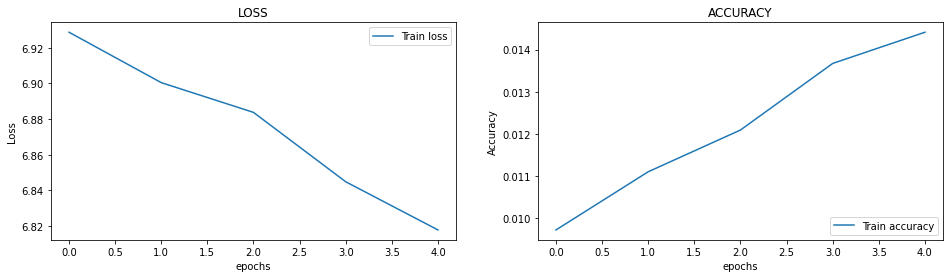




Batch4: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 101s 77ms/step - loss: 6.8750 - accuracy: 0.0126
Epoch 2/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.8174 - accuracy: 0.0143
Epoch 3/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.7928 - accuracy: 0.0153
Epoch 4/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.7605 - accuracy: 0.0162
Epoch 5/5
312/312 [==============================] - 36s 115ms/step - loss: 18.2185 - accuracy: 0.0010
Accuracy of Test data is: 0.10216346709057689 %


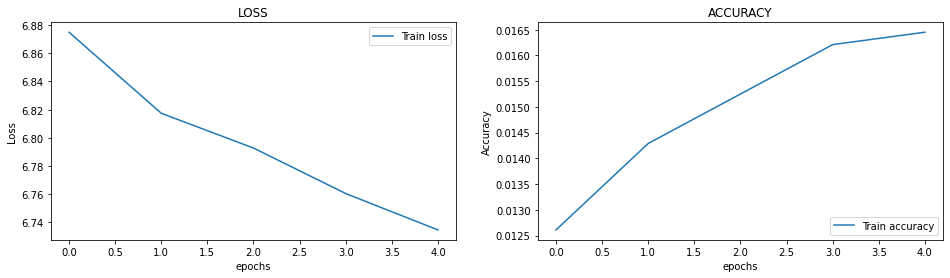




Batch5: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 99s 75ms/step - loss: 6.8002 - accuracy: 0.0143
Epoch 2/5
1250/1250 [==============================] - 94s 75ms/step - loss: 6.7529 - accuracy: 0.0152
Epoch 3/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.7190 - accuracy: 0.0166
Epoch 4/5
1250/1250 [==============================] - 94s 76ms/step - loss: 6.6984 - accuracy: 0.0170
Epoch 5/5
312/312 [==============================] - 36s 114ms/step - loss: 8.2036 - accuracy: 0.0051
Accuracy of Test data is: 0.5068108905106783 %


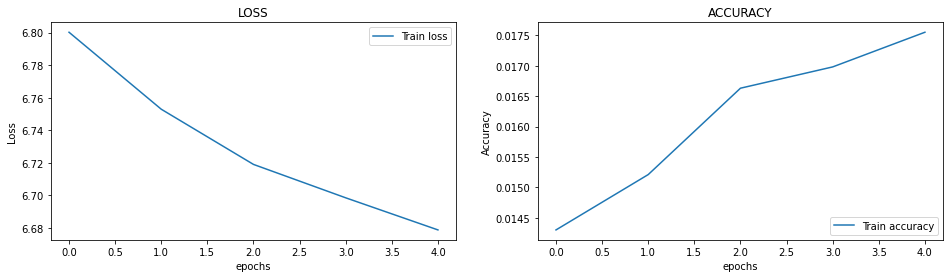




Batch6: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 99s 75ms/step - loss: 6.7624 - accuracy: 0.0159
Epoch 2/5
1250/1250 [==============================] - 94s 75ms/step - loss: 6.7149 - accuracy: 0.0167
Epoch 3/5
1250/1250 [==============================] - 94s 76ms/step - loss: 6.6836 - accuracy: 0.0174
Epoch 4/5
1250/1250 [==============================] - 94s 75ms/step - loss: 6.6654 - accuracy: 0.0180
Epoch 5/5
312/312 [==============================] - 37s 118ms/step - loss: 8.0763 - accuracy: 0.0054
Accuracy of Test data is: 0.5408653989434242 %


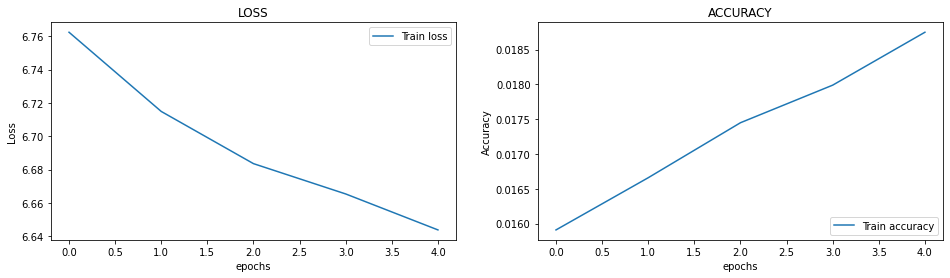




Batch7: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 99s 75ms/step - loss: 6.7243 - accuracy: 0.0160
Epoch 2/5
1250/1250 [==============================] - 94s 75ms/step - loss: 6.6764 - accuracy: 0.0170
Epoch 3/5
1250/1250 [==============================] - 94s 75ms/step - loss: 6.6471 - accuracy: 0.0186
Epoch 4/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.6295 - accuracy: 0.0191
Epoch 5/5
312/312 [==============================] - 36s 115ms/step - loss: 8.4725 - accuracy: 0.0047
Accuracy of Test data is: 0.4707532003521919 %


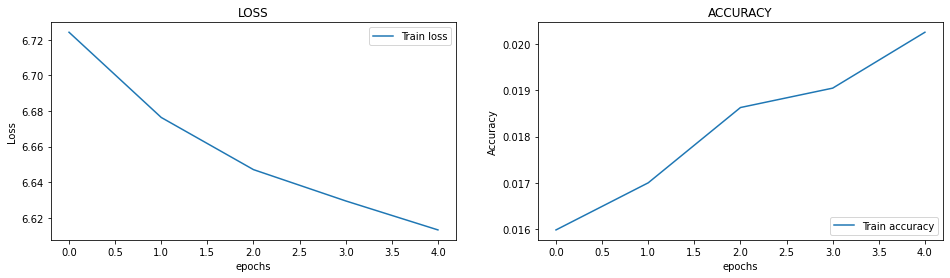




Batch8: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 101s 76ms/step - loss: 6.6949 - accuracy: 0.0171
Epoch 2/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.6450 - accuracy: 0.0189
Epoch 3/5
1250/1250 [==============================] - 94s 76ms/step - loss: 6.6206 - accuracy: 0.0193
Epoch 4/5
1250/1250 [==============================] - 93s 75ms/step - loss: 6.6039 - accuracy: 0.0190
Epoch 5/5
312/312 [==============================] - 36s 115ms/step - loss: 9.2035 - accuracy: 0.0035
Accuracy of Test data is: 0.35056089982390404 %


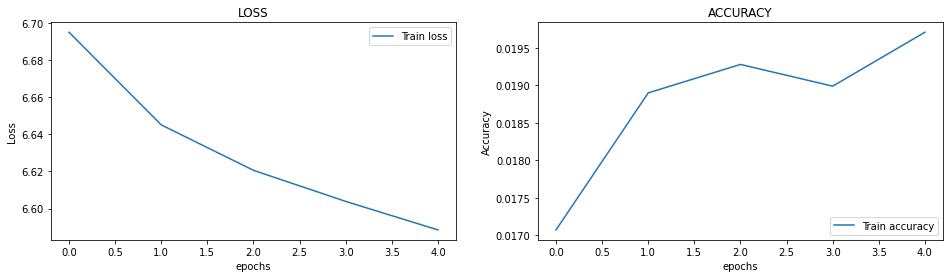




Batch9: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 99s 75ms/step - loss: 6.6797 - accuracy: 0.0163
Epoch 2/5
1250/1250 [==============================] - 92s 74ms/step - loss: 6.6308 - accuracy: 0.0178
Epoch 3/5
1250/1250 [==============================] - 94s 75ms/step - loss: 6.6063 - accuracy: 0.0191
Epoch 4/5
1250/1250 [==============================] - 93s 74ms/step - loss: 6.5865 - accuracy: 0.0198
Epoch 5/5
312/312 [==============================] - 36s 116ms/step - loss: 8.8121 - accuracy: 0.0046
Accuracy of Test data is: 0.4607371985912323 %


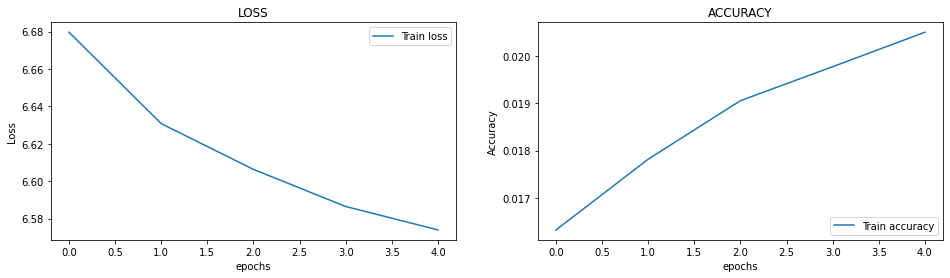




Batch10: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 98s 75ms/step - loss: 6.6655 - accuracy: 0.0175
Epoch 2/5
1250/1250 [==============================] - 93s 75ms/step - loss: 6.6152 - accuracy: 0.0187
Epoch 3/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.5934 - accuracy: 0.0196
Epoch 4/5
1250/1250 [==============================] - 95s 76ms/step - loss: 6.5771 - accuracy: 0.0200
Epoch 5/5
312/312 [==============================] - 36s 115ms/step - loss: 7.1688 - accuracy: 0.0087
Accuracy of Test data is: 0.8653846569359303 %


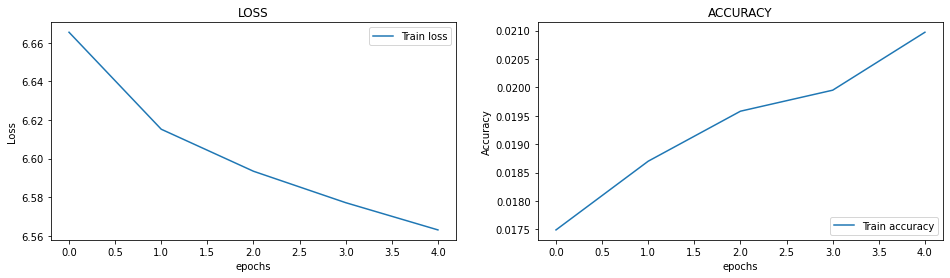




Batch11: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 99s 75ms/step - loss: 6.6464 - accuracy: 0.0177
Epoch 2/5
1250/1250 [==============================] - 93s 75ms/step - loss: 6.6037 - accuracy: 0.0199
Epoch 3/5
1250/1250 [==============================] - 93s 74ms/step - loss: 6.5756 - accuracy: 0.0210
Epoch 4/5
1250/1250 [==============================] - 93s 74ms/step - loss: 6.5604 - accuracy: 0.0209
Epoch 5/5
312/312 [==============================] - 35s 113ms/step - loss: 7.0186 - accuracy: 0.0114
Accuracy of Test data is: 1.143830083310604 %


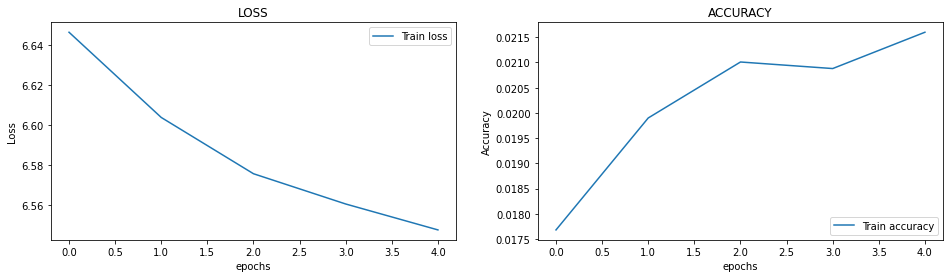




Batch12: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 98s 74ms/step - loss: 6.6343 - accuracy: 0.0184
Epoch 2/5
1250/1250 [==============================] - 93s 74ms/step - loss: 6.5880 - accuracy: 0.0202
Epoch 3/5
1250/1250 [==============================] - 93s 74ms/step - loss: 6.5639 - accuracy: 0.0209
Epoch 4/5
1250/1250 [==============================] - 93s 75ms/step - loss: 6.5457 - accuracy: 0.0216
Epoch 5/5
312/312 [==============================] - 36s 115ms/step - loss: 6.9319 - accuracy: 0.0128
Accuracy of Test data is: 1.2840544804930687 %


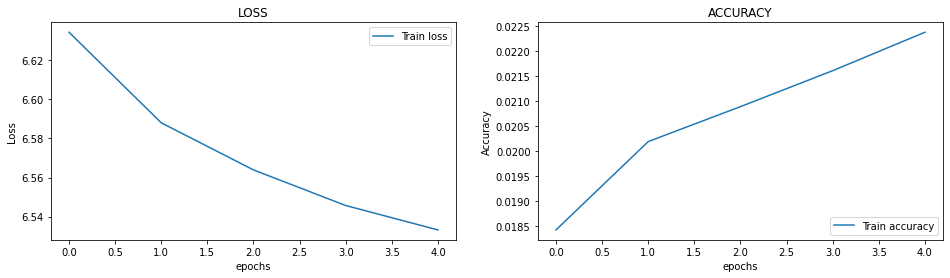




Batch13: Training Data Dim (100000, 8, 8, 3)   Label Data Dim: (100000,)
Epoch 1/5
1250/1250 [==============================] - 98s 74ms/step - loss: 6.6133 - accuracy: 0.0189
Epoch 2/5
1250/1250 [==============================] - 92s 74ms/step - loss: 6.5708 - accuracy: 0.0204
Epoch 3/5
1250/1250 [==============================] - 93s 74ms/step - loss: 6.5507 - accuracy: 0.0207
Epoch 4/5
1250/1250 [==============================] - 92s 74ms/step - loss: 6.5317 - accuracy: 0.0218
Epoch 5/5
312/312 [==============================] - 36s 113ms/step - loss: 7.4402 - accuracy: 0.0077
Accuracy of Test data is: 0.7712339516729116 %


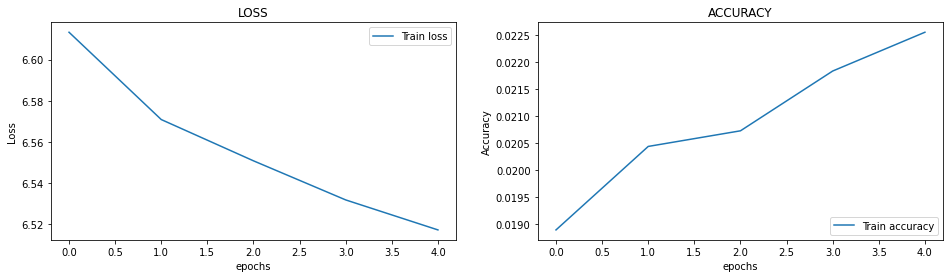

In [7]:
Training_Batch = [1,3,4,5,6,7,8,9,10,11,12,13]
plo_acc = []
plo_loss = []
epcs = 5

training_batch_size = batch_size
tst_batch_size = Test_batch_size

#num_val_samples = len(X_Val)
num_tst_samples = len(X_Tst)


for Batch_number in Training_Batch:
    weights_path ='Weights_1x1_pass1_Batch' + str(Batch_number) + '.h5'
    
    X, Y = Data_Loader(Batch_number)
    X = X[:,:,:,0]    #single channel mode
    Y=Y.astype(np.int16)
    Y = tf.one_hot(Y, 1000)
    num_train_samples = len(X)
    X = Augmentator(X, Label=0, crop_level=1, Append=False) #Replace all X data with Hcrop_1x1 values

    train_generator = Tflow_Custom_Generator(X, Y) #Custom generator to Resize images
    train_dataset = tf.data.Dataset.from_generator(generator=train_generator, output_types=(tf.float32, tf.int16), 
                                             output_shapes=(x_shape, y_shape) )

    # Parallelize the augmentation.
    #dataset = dataset.map( augment, num_parallel_calls=AUTOTUNE, deterministic=False )  # Order does not matter.
    train_dataset = train_dataset.repeat().batch(batch_size, drop_remainder=False) #, num_parallel_calls=AUTOTUNE

    #train_dataset = train_dataset.cache("traincache.txt")
    train_dataset = train_dataset.shuffle(100, reshuffle_each_iteration=True)

    # Prefetch some batches.
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    tr_hist = model_final.fit(
            train_dataset, steps_per_epoch = num_train_samples // training_batch_size, epochs=epcs, verbose=1, 
            use_multiprocessing=True, workers=12) #, workers=2 , max_queue_size=150  use_multiprocessing=True


    model_final.save_weights(weights_path) 
    
    #file_name = weights_path
    #url = url_converter(file_name,original_link)
    #window_open(url)

    acc = model_final.evaluate(Test_dataset, steps= num_tst_samples // tst_batch_size, verbose = 1)    #Test Data Accuracy
    print(f'Accuracy of Test data is: {acc[1]*100} %')

    #Plot graphs
    #plt.figure(figsize=(16,4))  
    #plt.subplot(1, 2, 1)

    #plt.plot(tr_hist.history['loss'],label="Train loss")
    ##plt.plot(tr_hist.history['val_loss'],label="Validation loss", linestyle='-')
    
    plo_loss.append(tr_hist.history['loss'])
    
    #plt.title('LOSS')
    #plt.ylabel('Loss')
    #plt.xlabel('epochs')
    #plt.legend(loc='upper right')

    #plt.subplot(1, 2, 2)
    #plt.plot(tr_hist.history['accuracy'],label="Train accuracy")
    ##plt.plot(tr_hist.history['val_accuracy'],label="Validation accuracy", linestyle='-')
    
    plo_acc.append(tr_hist.history['accuracy'])
    
    #plt.title('ACCURACY')
    #plt.ylabel('Accuracy')
    #plt.xlabel('epochs')
    #plt.legend(loc='lower right')
    #plt.show()
    print()
    print()
    print()
    del train_generator
    del train_dataset
    del X
    del Y
    #device = cuda.get_current_device()
    #device.reset()
    
    gc.collect()
       

        
        
#Final PLOT
plo_loss = np.array(plo_loss).flatten()
plo_acc = np.array(plo_acc).flatten()
#plo_loss = plo_loss[1:]
#plo_acc=plo_acc.flatten()
#plo_loss=plo_loss.flatten()

plt.figure(figsize=(16,4))  
plt.subplot(1, 2, 1)

plt.plot(plo_loss,label="Train loss")

plt.title('LOSS')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(plo_acc,label="Train accuracy")

plt.title('ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

**Calculate the accuracy on hidden dataset**

In [32]:
tst_batch_size = Test_batch_size

num_tst_samples = len(X_Tst)

acc = model_final.evaluate(Test_dataset, steps= num_tst_samples // tst_batch_size, verbose = 1)    #Test Data Accuracy
print(f'Accuracy of Test data is: {acc[1]*100} %')

312/312 [==============================] - 36s 114ms/step - loss: 7.4397 - accuracy: 0.0077
Accuracy of Test data is: 0.7712339516729116 %


**Create a custom Prediction Generator**

In [33]:
def Tflow_Custom_Generator_Pred(X_Dat_Val):   
    def generator():
        for i in range(len(X_Dat_Val)):
            image = Image_Pyramid_Scaler(X_Dat_Val[i], 0, 0, 3)  #filter_flag, cv_flag, channels_flag  .astype(np.float32)
            # The generator-y part: yield the next training batch            
            yield image
    return generator



dict_Validation = load(r'../input/processed-total-dataset/Processed_Val.npz') 
Val = dict_Validation['arr_0'] 

data_min = np.min(Val, axis=(1,2), keepdims=True)
data_max = np.max(Val, axis=(1,2), keepdims=True)

Val = (Val - data_min) / (data_max - data_min)
Val = Val[:,:,:,0] 

del dict_Validation



Pred_batch_size = 89
num_pred_samples = len(Val)

###===================== Pred Gen.

Pred_generator = Tflow_Custom_Generator_Pred(Val) #Custom generator to Resize images
Pred_dataset = tf.data.Dataset.from_generator(generator=Pred_generator, output_types=(tf.float32), 
                                         output_shapes=(x_shape) )


# Parallelize the augmentation.
#Pred_dataset = Pred_dataset.map( augment, num_parallel_calls=AUTOTUNE, deterministic=False )  # Order does not matter.
#Pred_dataset = Pred_dataset.repeat().batch(Pred_batch_size, drop_remainder=False) # num_parallel_calls=AUTOTUNE

Pred_dataset = Pred_dataset.batch(Pred_batch_size, drop_remainder=False) # num_parallel_calls=AUTOTUNE
# Prefetch some batches.
Pred_dataset = Pred_dataset.prefetch(tf.data.AUTOTUNE)


**Make predictions and EXPORT**

In [34]:
BA = model_final.predict(Pred_dataset, steps= num_pred_samples // Pred_batch_size, verbose = 1, workers=12)

BATCH = np.argmax(BA, axis=1)

BATCH=BATCH.astype('int').astype('<U4') 
print(BATCH.dtype) 
print(BATCH.shape) 
print(BATCH)



542/542 [==============================] - 12s 21ms/step
<U4
(48238,)
['934' '437' '43' ... '110' '671' '169']


In [35]:

#Save to CSV

ind = np.arange(1,Val.shape[0]+1, dtype = np.int32)
print(ind.shape)

predictions = pd.DataFrame(BATCH)

column_names = ["Id", "Class"]
combine_DF=pd.DataFrame(columns = column_names)

combine_DF['Id']=ind
combine_DF['Class']=BATCH

compression_opts = dict(method='zip',archive_name='OSAMA_CNN.csv')
combine_DF.to_csv('OSAMA_CNN_tst22_GPU.zip', index=False,compression=compression_opts)

#combine_DF.to_csv('data1.csv', index = False)            # Export pandas DataFrames to CSV
#combine_DF.to_csv('data2.csv', index = False)


(48238,)
